In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from calendar import monthrange
import cdsapi
from datetime import datetime, timedelta
import glob

### Configuration

In [2]:
# catchment area threshold
area = 2e9 # m²
leadtime = np.timedelta64(timedelta(hours=48))

```Python
c = cdsapi.Client()

year = 2020
month = 1
days = monthrange(year, month)[1]

c.retrieve('efas-forecast',
           {'originating_centre': 'ecmwf',
            'product_type': 'high_resolution_forecast',
            'variable': 'river_discharge_in_the_last_6_hours',
            'model_levels': 'surface_level',
            'year': f'{year}',
            'month': f'{month:02}',
            'day': [f'{d:02}' for d in range(1, days)],
            'time': '00:00',
            'leadtime_hour': [str(lt) for lt in range(0, 241, 6)],
            'format': 'netcdf',
            'area': [43.5, -9, 36, 3]},
           'download.nc')
```

In [6]:
# load data
ds = xr.open_dataset('../data/CDS/date_2021-11-23.nc')

ds

<xarray.Dataset>
Dimensions:                       (y: 233, x: 257, step: 41)
Coordinates:
  * y                             (y) float64 2.508e+06 2.502e+06 ... 1.348e+06
  * x                             (x) float64 2.592e+06 2.598e+06 ... 3.872e+06
    time                          datetime64[ns] ...
  * step                          (step) timedelta64[ns] 0 days 00:00:00 ... ...
    surface                       float64 ...
    latitude                      (y, x) float64 ...
    longitude                     (y, x) float64 ...
    valid_time                    (step) datetime64[ns] ...
Data variables:
    dis06                         (step, y, x) float32 ...
    lambert_azimuthal_equal_area  int32 ...
    land_binary_mask              (y, x) int8 ...
    upArea                        (y, x) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2022-11-28T10:10 GRIB to CDM+CF via cfgrib-0.9.9...

In [8]:
ds['dis06']

<xarray.DataArray 'dis06' (step: 41, y: 233, x: 257)>
[2455121 values with dtype=float32]
Coordinates:
  * y           (y) float64 2.508e+06 2.502e+06 ... 1.352e+06 1.348e+06
  * x           (x) float64 2.592e+06 2.598e+06 ... 3.868e+06 3.872e+06
    time        datetime64[ns] 2021-11-23
  * step        (step) timedelta64[ns] 0 days 00:00:00 ... 10 days 00:00:00
    surface     float64 0.0
    latitude    (y, x) float64 43.41 43.43 43.44 43.45 ... 35.05 35.05 35.06
    longitude   (y, x) float64 -11.64 -11.59 -11.53 -11.47 ... 5.007 5.061 5.115
    valid_time  (step) datetime64[ns] 2021-11-23 ... 2021-12-03
Attributes:
    GRIB_paramId:                    240023
    GRIB_dataType:                   fc
    GRIB_numberOfPoints:             59881
    GRIB_typeOfLevel:                surface
    GRIB_stepUnits:                  1
    GRIB_stepType:                   avg
    GRIB_gridType:                   lambert_azimuthal_equal_area
    GRIB_NV:                         0
    GRIB_cfName:                     unknown
    GRIB_cfVarName:                  dis06
    GRIB_gridDefinitionDescription:  Lambert azimuthal equal area projection
    GRIB_missingValue:               9999
    GRIB_name:                       Mean discharge in the last 6 hours
    GRIB_shortName:                  dis06
    GRIB_units:                      m**3 s**-1
    long_name:                       Mean discharge in the last 6 hours
    units:                           m**3 s**-1
    standard_name:                   unknown
    grid_mapping:                    lambert_azimuthal_equal_area

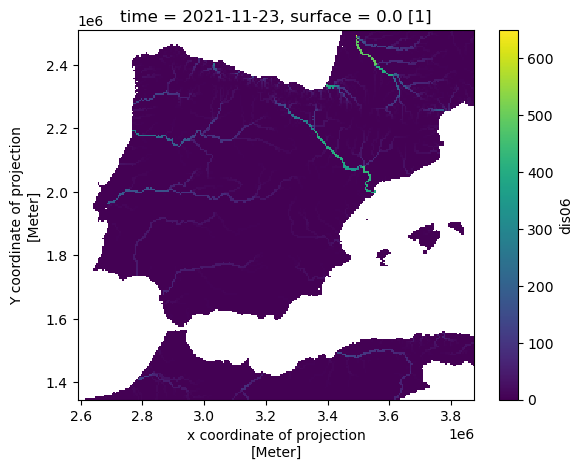

In [16]:
ds['dis06'].mean('step').plot();

In [13]:
# catchment area
data.upArea.plot();

NameError: name 'data' is not defined

## Discharge data

In [144]:
# discharge data
dis = ds['dis06']

### Mean discharge in rivers

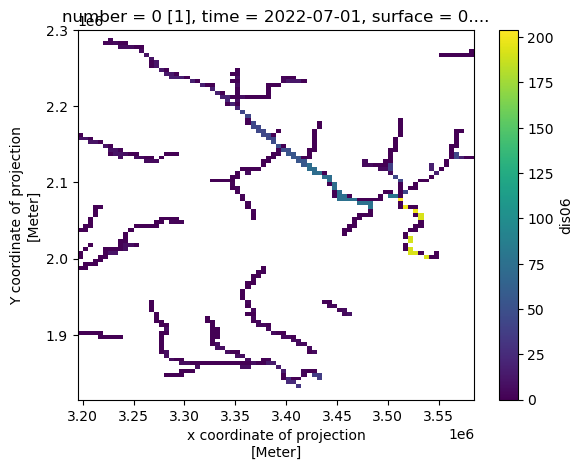

In [143]:
# mask for rivers
mask = data.upArea >= 2e9
# calculate mean discharge for the mask
mean_dis = dis.where(mask).mean('step')
# plot
mean_dis.plot();

### Discharge timeseries
Extract the discharge timeseries for the cell with the largest mean discharge.

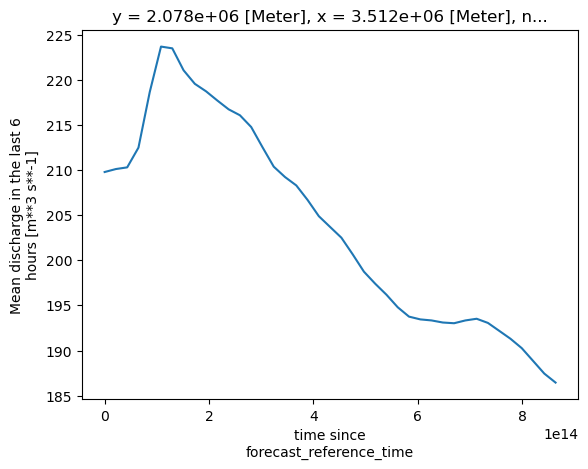

In [152]:
# point with the largest mean discharge
point = mean_dis.argmax(dim=['y', 'x'])
# extract series
timeseries = dis.isel(point)
# plot
timeseries.plot();

### Maximum discharge
#### In a single forecast

In [159]:
mask_area = data.upArea >= area

In [169]:
mask_leadtime = data.step >= leadtime)

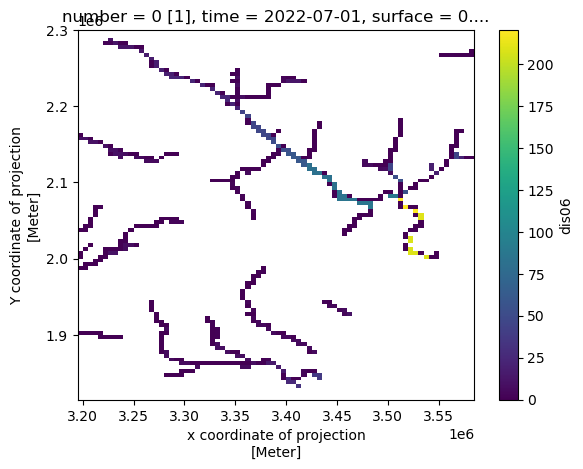

In [175]:
max_dis = dis.where(mask_area).sel(step=slice(leadtime,None)).max('step')
max_dis.plot();

#### For the whole month of July 2022

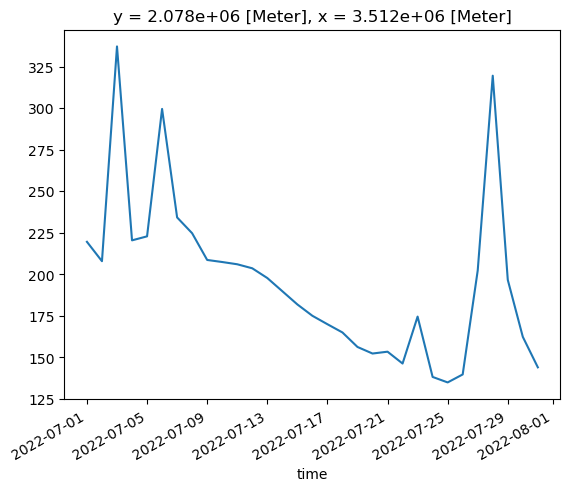

In [259]:
files = glob.glob('../data/CDS/*.nc')
dates = [datetime.strptime(file.split('_')[-1].split('.')[0], '%Y-%m-%d') for file in files]
array = np.empty((len(dates), dis.shape[1], dis.shape[2]))
for d, (date, file) in enumerate(zip(dates, files)):
    print(date, end='\r')
    # load dataset
    ds = xr.open_dataset(file)
    # discharge data
    array[d,:,:] = ds.dis06.where(mask_area).sel(step=slice(leadtime,None)).max('step')

# create xarray
forecast = xr.DataArray(array, dims=('time', 'y', 'x'), coords={'time': dates, 'y': ds.y, 'x': ds.x})

# plot the forecast series for a point
forecast.isel(y=point['y'].data, x=point['x'].data).plot();

#### Variation for the forecast of the 2022-07-09 18:00